## Read in Candidate/Confirmed Keys

In [1]:
import numpy as np
import pandas as pd
import sys
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

from scipy.signal import savgol_filter
from scipy.signal import medfilt
 
import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.metrics import confusion_matrix

# Plot params
# mpl.rcParams['figure.figsize'] = (12, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
confirmed = "./data/raw/k2candidates_2020.10.28_02.32.01.csv"

con_df = pd.read_csv(confirmed)

con_df.head()

In [ ]:
con_df = con_df[['epic_name', 'epic_candname', 'k2_campaign', 'k2c_disp']]
con_df = con_df[con_df.k2c_disp != "FALSE POSITIVE"]

con_df = con_df.drop_duplicates(['epic_name'])
print(con_df.k2_campaign.unique())

con_df = con_df[['epic_name', 'k2c_disp']]

con_df = con_df.set_index('epic_name')
con_df.columns = ['label']

con_df

In [ ]:
candidates = con_df[con_df.label == "CANDIDATE"]
confirmed = con_df[con_df.label == "CONFIRMED"]

print(f"Confirmed Planets: {confirmed.shape}\n")
print(f"Candidate Planets: {candidates.shape}\n")

candidates

## Read in Light Curves

In [ ]:
def combine_lightcurves(folder_path, recursive=True):
    if recursive:
        # Get all the sub directories
        folders = glob.glob(folder_path)
    else:
        # Set parent directory as main
        folders = [folder_path]
    
    df_list = []
    epic_list = []
    for folder in folders:
        sys.stdout.write(f'\nReading Folder: {folder}\n')
        # Grab a list of all the txt files
        files = glob.glob(folder + '/*.txt')
        # Loop through the files
        sys.stdout.write('Importing EPICs: ')
        for i, file in enumerate(files):
            # Extract EPIC number from filename
            lc_idx = file.find('lightcurve')
            new_str = file[lc_idx:]
            epic_start_idx = new_str.find('_')
            epic_end_idx = new_str.find('-')
            epic = new_str[epic_start_idx + 1:epic_end_idx]
            
            if epic not in epic_list:
                epic_list.append(epic)
                # Import
                if i % 100 == 0:
                    sys.stdout.write('.')
                    sys.stdout.flush()
                df = pd.read_csv(file)
                df = df.drop(columns=[' Corrected Flux'])
                df.columns = [f'EPIC {epic}']
                df = df.reset_index(drop=True)

                df_list.append(df)
    
    print(f'\nCombining {len(df_list)} DataFrames')
    # Once all the df's have been extracted combine them
    super_df = pd.concat(df_list, axis=1)
    
    return super_df

def shift_and_fill(df):
    # For each column count the number of NaN's (which will be at the end) and then shift by half that amount, then bfill & ffill
    for col in df.columns:
        shift = df[col].isna().sum()
        if shift:
            df[col] = df[col].shift(shift // 2)
        else:
            continue

    df = df.ffill()
    df = df.bfill()
    
    return df

def combine_labels(labels, df):
    temp_df = df.copy(deep=True).T
    output_df = temp_df.merge(right=labels, left_index=True, right_index=True, how='left')
    output_df['label'] = output_df['label'].fillna('NONE')
    
    return output_df

In [ ]:
# Read in and create light curves
unfilled = combine_lightcurves('data/raw/Campaigns/*', recursive=True)
# Shift and ffill/bfill data
filled = shift_and_fill(unfilled)

In [ ]:
# Plot data
columns = unfilled.columns
unfilled[columns[:5]].plot(subplots=True, figsize=(20,10))

columns = filled.columns
filled[columns[:5]].plot(subplots=True, figsize=(20,10))

In [ ]:
# Coerce data to numeric types
unfilled = unfilled.apply(pd.to_numeric, errors='coerce')
filled = filled.apply(pd.to_numeric, errors='coerce')

In [ ]:
# Join labels to lightcurve data
unfilled = combine_labels(con_df, unfilled)
filled = combine_labels(con_df, filled)

In [ ]:
con = unfilled.query('label == "CONFIRMED"')
con[-10:].T.drop('label').plot(subplots=True, figsize=(20, len(con[-10:]) * 4))

In [ ]:
can = unfilled.query('label == "CANDIDATE"')
can[-10:].T.drop('label').plot(subplots=True, figsize=(20, len(can[-10:]) * 4))

In [ ]:
unfilled.to_hdf('unfilled_transit_data.h5', key='stage', mode='w', index=True)
filled.to_hdf('filled_transit_data.h5', key='stage', mode='w', index=True)

# Rescale and Realign Kaggle data

In [ ]:
kaggle_test = "./data/raw/exoTest.csv"
kaggle_ds = "./data/raw/exoTrain.csv"
test_df = pd.read_csv(kaggle_test)
kg_df = pd.read_csv(kaggle_ds)
test_df.columns = [x.lower() for x in test_df.columns]
test_df.columns = ['label'] + [x[5:] for x in test_df.columns if 'label' not in x]
kg_df.columns = [x.lower() for x in kg_df.columns]
kg_df.columns = ['label'] + [x[5:] for x in kg_df.columns if 'label' not in x]
test_df.index = ['EPIC '+ str(x) for x in test_df.index]
kg_df.index = ['EPIC '+ str(x) for x in kg_df.index]
test_df

In [ ]:
# Normalise these
labels = kg_df[['label']]
kg_df = kg_df.drop('label', axis=1)

# Rescale to the same range as the K2 data
kg_df = (((kg_df - np.mean(kg_df, axis=1).values.reshape(-1,1)) / 
           np.std(kg_df, axis=1).values.reshape(-1,1)) / 10 ) + 1

kg_df = pd.concat([kg_df, labels], axis=1)

In [ ]:
labels = test_df[['label']]
test_df = test_df.drop('label', axis=1)

# Rescale to the same range as the K2 data
test_df = (((test_df - np.mean(test_df, axis=1).values.reshape(-1,1)) / 
           np.std(test_df, axis=1).values.reshape(-1,1)) / 10 ) + 1

test_df = pd.concat([test_df, labels], axis=1)

In [ ]:
kg_df.to_csv('kaggle_processed_train.csv', index=True)
test_df.to_csv('kaggle_processed_test.csv', index=True)

# Combine Test Datasets

In [22]:
k2 = pd.read_hdf('./data/unfilled_transit_data.h5')

In [23]:
ktrain = pd.read_csv('./data/kaggle_processed_train.csv', index_col=0)
ktest = pd.read_csv('./data/kaggle_processed_test.csv', index_col=0)

In [24]:
# Convert column names (features)
ktrain.columns = [str(x) for x in ktrain.columns]
k2.columns = [str(x) for x in k2.columns]

# Extract candidates --> we will run the model on these at the end to try and find new planets!!!
candidates = k2[k2.label == 'CANDIDATE'].copy()

# Extract K2 non/confirmed
k2 = k2[k2.label.isin(['NONE', 'CONFIRMED'])].copy()
k2

,0,1,2,3,4,5,6,7,8,9,...,3714,3715,3716,3717,3718,3719,3720,3721,3722,label
EPIC 202127354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONE
EPIC 202088984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONE
EPIC 202137561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONE
EPIC 202087516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONE
EPIC 202065813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPIC 211769933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONE
EPIC 211781539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONE
EPIC 211346196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONE
EPIC 212025280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NONE


In [25]:
def align(row, front=True):
    count = 0
    for val in row:
        if np.isnan(val):
            count += 1
        else:
            break
    if front:
        count = -count
    else:
        count += 1

    return row.shift(count)

# Convert labels to binary (0=no planet, 1=planet)
k2.loc[k2.label == 'NONE', 'label'] = 0
k2.loc[k2.label == 'CONFIRMED', 'label'] = 1
ktrain.loc[ktrain.label == 1, 'label'] = 0
ktrain.loc[ktrain.label == 2, 'label'] = 1
k2_labels = k2.pop('label')
ktrain_labels = ktrain.pop('label')

# Front align all the data
k2 = k2.apply(align, axis=1)
ktrain = ktrain.apply(align, axis=1)

# Subset the K2 data so it is equivalent length/features as the kaggle data
k2 = k2.shift(1, axis=1).drop('0', axis=1)[ktrain.columns]

# Remove any K2 data which does not meet the minimum feature length requirements
k2 = k2[~k2.isna().any(axis=1)]

# merge the labels back 
k2 = k2.merge(k2_labels, left_index=True, right_index=True)
ktrain = ktrain.merge(ktrain_labels, left_index=True, right_index=True)

In [26]:
# Concatenate the training set
train = k2.copy()
train.sample(5)

,1,2,3,4,5,6,7,8,9,10,...,3189,3190,3191,3192,3193,3194,3195,3196,3197,label
EPIC 205538404,0.985244,0.984446,0.984763,0.983976,0.983788,0.983735,0.982422,0.987166,0.986239,0.987820,...,1.009434,1.010105,1.010513,1.008975,1.008961,1.008501,1.008692,1.009293,1.010019,0
EPIC 246433684,0.973821,0.962401,0.956732,0.969469,0.976004,0.960822,0.962475,0.961072,0.965705,0.974092,...,0.987424,0.958846,1.935321,0.986120,0.954556,0.970013,0.964553,0.964659,1.008373,0
EPIC 212429468,1.027703,1.024982,1.026211,1.029303,1.028700,1.029545,1.026453,1.025559,1.027365,1.024818,...,1.041666,1.041318,1.042388,1.042029,1.042159,1.041935,1.042737,1.040535,1.040694,0
EPIC 211822117,0.979365,0.983965,0.982440,0.985845,0.984496,0.984461,0.984413,0.983449,0.981801,0.983182,...,1.006254,1.007645,1.008093,1.008146,1.008979,1.007530,1.008333,1.008476,1.007793,0
EPIC 212087098,0.993187,0.994950,0.993885,0.993774,0.993322,0.993403,0.992303,0.992041,0.992260,0.992468,...,1.014554,1.016199,1.013557,1.014769,1.014359,1.014071,1.015347,1.015918,1.014159,0


In [27]:
ktest.columns = [str(x) for x in ktest.columns]
test = ktest.copy()
test.loc[test.label == 1, 'label'] = 0
test.loc[test.label == 2, 'label'] = 1
test.sample(5)

,1,2,3,4,5,6,7,8,9,10,...,3189,3190,3191,3192,3193,3194,3195,3196,3197,label
EPIC 555,1.032593,1.041885,1.019953,1.047747,1.038561,1.006896,1.025505,1.033760,1.027440,0.998592,...,1.014866,1.014335,1.037745,1.035998,1.020140,0.923691,0.895667,0.870388,0.875548,0
EPIC 500,0.647990,0.724621,0.650215,0.710435,0.727542,0.816134,0.818498,0.769960,0.816551,0.838803,...,0.940190,0.976489,1.092062,1.079962,1.037127,1.117096,0.929203,0.929064,0.883586,0
EPIC 113,0.865905,0.842582,0.875893,0.874442,0.869532,0.880971,0.927951,0.891126,0.941398,0.938385,...,1.118776,1.176582,1.163358,1.167989,1.187183,0.940059,0.961318,1.005397,0.999929,0
EPIC 512,0.737189,0.763907,0.727209,0.691769,0.670630,0.710550,0.691140,0.660650,0.631889,0.618844,...,0.966649,1.041773,1.073364,1.055997,1.101810,0.895532,0.858441,0.880837,0.785910,0
EPIC 379,1.047751,1.092297,1.094616,1.071286,1.002795,1.063441,1.062622,1.089841,1.009071,1.048228,...,1.034857,1.110238,1.039019,1.033971,1.062008,1.089227,1.050820,1.066511,0.988742,0


In [28]:
kplanets = (ktrain.label == 1).sum()
knon_planets = (ktrain.label == 0).sum()
ktotal = len(ktrain.label)

planets = (train.label == 1).sum()
non_planets = (train.label == 0).sum()
total = len(train.label)

test_planets = (test.label == 1).sum()
test_non_planets = (test.label == 0).sum()
test_total = len(test.label)

print(f'TRAIN \nNumber of planets: {kplanets}')
print(f'Number of non-planets: {knon_planets}')
print(f'Percentage of planets: {(100 * kplanets/ktotal) :.2f}%')

print(f'TRAIN \nNumber of planets: {planets}')
print(f'Number of non-planets: {non_planets}')
print(f'Percentage of planets: {(100 * planets/total) :.2f}%')

print(f'\nTEST\nNumber of planets: {test_planets}')
print(f'Number of non-planets: {test_non_planets}')
print(f'Percentage of planets: {(100 * test_planets/total) :.2f}%')

TRAIN 
Number of planets: 37
Number of non-planets: 5050
Percentage of planets: 0.73%
TRAIN 
Number of planets: 153
Number of non-planets: 197965
Percentage of planets: 0.08%

TEST
Number of planets: 5
Number of non-planets: 565
Percentage of planets: 0.00%


# Start of Data Analysis

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

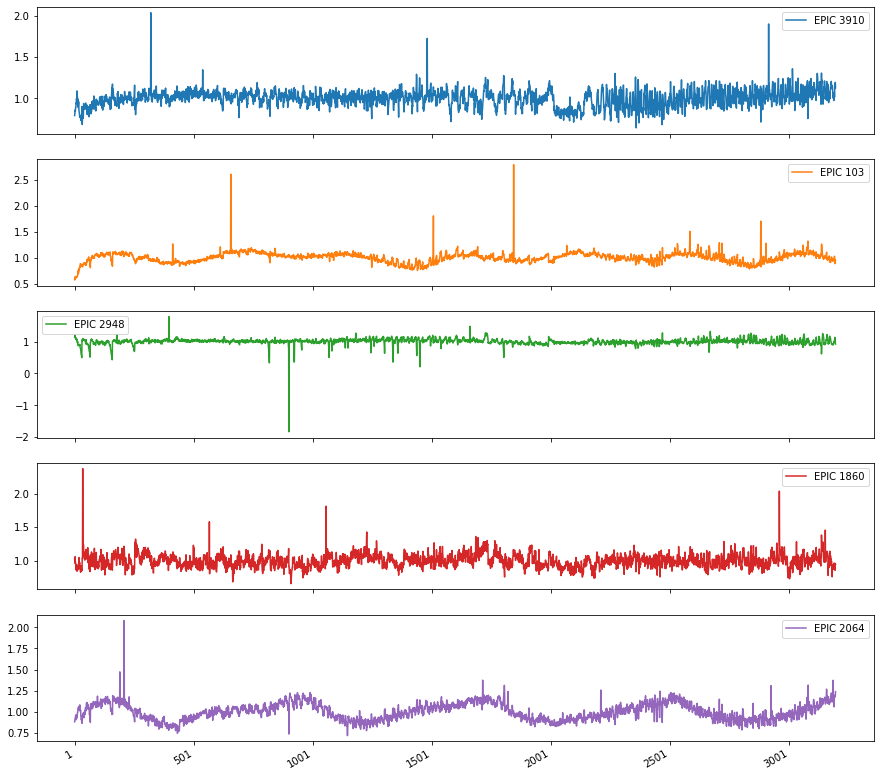

In [29]:
sample = ktrain.sample(5).drop('label', axis=1)
sample.T.plot(subplots=True, figsize=(15,15))

Lots of the longer samples appear to have outliers that drop to 0 near the end, we should smooth these out.

There are also lots of large upward spikes that we should also smooth out, they are most likely sensor errors/intensity spikes due to visual errors on the telescope

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

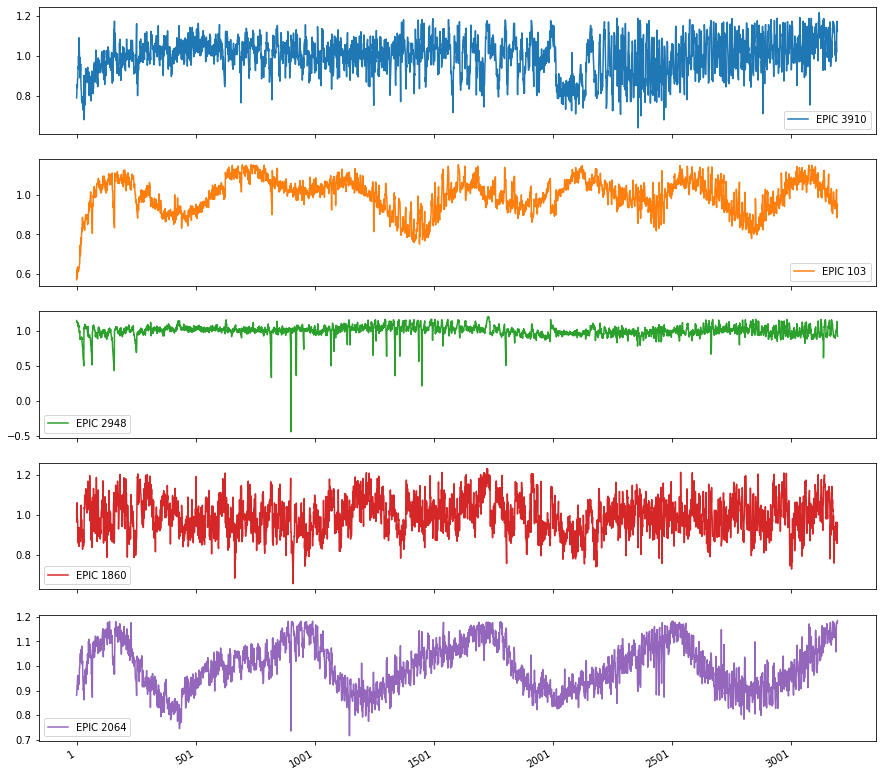

In [30]:
def zero_outlier_removal(df):
    for key in df.index:
        zero_mask = df.loc[key] <= 0
        for i, val in enumerate(zero_mask):
            if val:
                try:
                    if not zero_mask.iloc[i-1] and not zero_mask.iloc[i+1]:
                        df.loc[key].iloc[i] = df.loc[key].iloc[i-1:i+1].sum() - df.loc[key].iloc[i] / 3
                except IndexError:
                    continue
    return df


def spike_removal(df, perc_filter, window=7):
    for key in df.index:
        mean = df.loc[key][df.loc[key] != 0].mean()
        length = len(df.loc[key])
        reduce = int(length * (perc_filter/100))
        max_df = df.loc[key].sort_values(ascending=False)
        
        for i in range(0, int(reduce)):
            real_index = int(max_df.index[i])
            smoothed_val = 0
            count = 0
            for j in range(-int(window/2), int(window/2) + 1):
                if not j == 0:
                    try:
                        smoothed_val += df.loc[key].loc[str(real_index + j)]
                        count += 1
                    except KeyError:
                        continue
            
            smoothed_val = smoothed_val / count
            smoothed_val = smoothed_val if mean < smoothed_val else mean
            df.loc[key].loc[str(real_index)] = smoothed_val
            
    return df
# Remove single spikes to zero in the middle of the data
sample = zero_outlier_removal(sample)
# Remove 2% of the positive spikes
sample = spike_removal(sample, 2)

sample.T.plot(subplots=True, figsize=(15,15))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

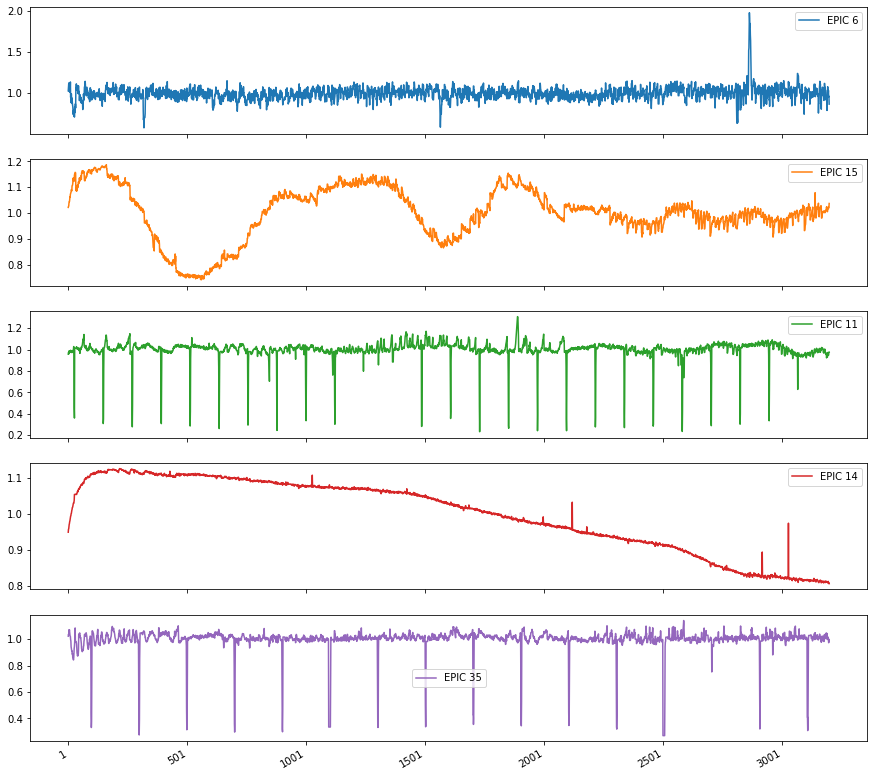

In [31]:
sample_true = ktrain[ktrain.label == 1].sample(5).drop('label', axis=1)

# Remove single spikes to zero in the middle of the data
sample_true = zero_outlier_removal(sample_true)
# Remove 2% of the positive spikes
sample_true = spike_removal(sample_true, 2)

splot = sample_true.copy()
splot[splot == 0] = np.nan
splot.T.plot(subplots=True, figsize=(15,15))

### Lets investigate the periodicity and noise of the signals. It is likely there will be lots of sensor noise.

We can see that a lot of the confirmed cases of exoplanets have a large amount of high frequency noise, which doesn't appear to be too periodic.

We can also see that there a lot of low frequency periodic behaviours in a lot of the confirmed cases, there could be many reasons for this sort of behaviour (changes of observation position etc) but it should be removed if possible to isolate the real signals.

We can use a median filter (scipy.medfilt) to remove the underlying signal noise, and we can apply a high order Savitzky-Golay filter to try and remove the low frequency periodic behaviour.

As a final processing step we can apply a fast fourier transform, to emphasise any periodic signals. Because of the nature of the signals we are looking for we know that a confirmed case will exhibit periodicity, so its a good idea to try and enhance this.

We will try without the FFT first.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

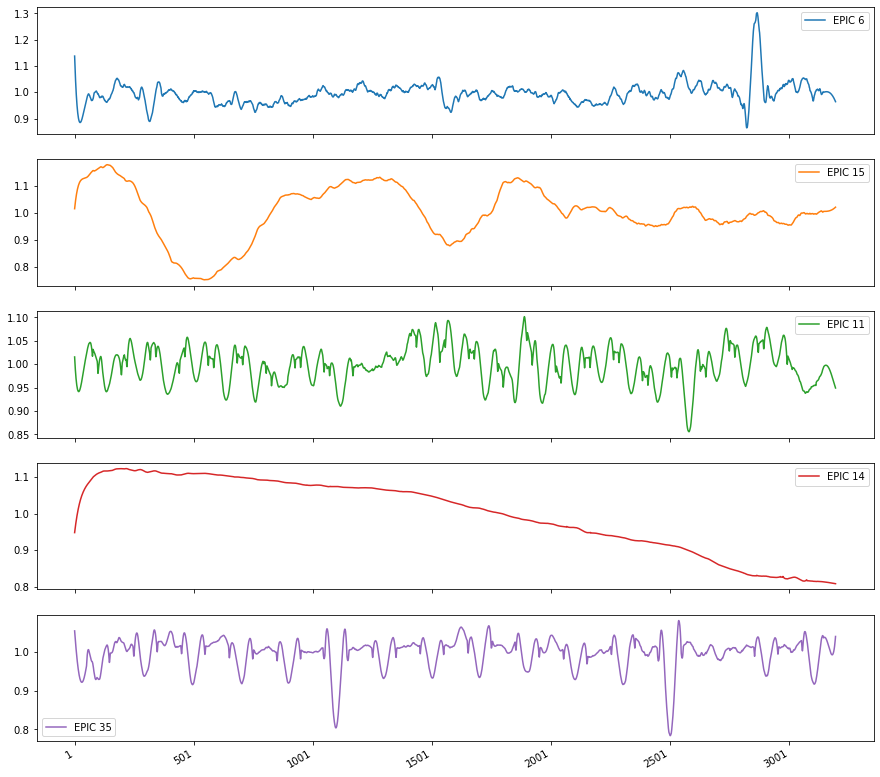

In [32]:
def frequency_filter(df, poly_order, window):
    out = []
    length = len(df.columns)
    for key in df.index:
        data = df.loc[key][df.loc[key] != 0]
        med = medfilt(data, (window + 1))
        sg = savgol_filter(data, window + 1, poly_order, deriv=0)
        extend = np.zeros(length - len(sg))
        sg = np.concatenate((sg, extend))
        df.loc[key] = sg
    return df

def fourier_transform(df):
    fft = pd.DataFrame(data=np.abs(np.fft.fft(df, axis=0)), columns=df.columns, index=df.index)
    return fft

s = sample_true.copy()
s = frequency_filter(sample_true, 4, 100)
# s = fourier_transform(s)

s[s == 0] = np.nan
s.T.plot(subplots=True, figsize=(15,15))

Now that we have figured out what out outlier removal and smoothing steps should be we need to apply this to the training/test data

In [33]:
ktrain_Y = ktrain.pop('label')
train_Y = train.pop('label')
test_Y = test.pop('label')

# Remove single spikes to zero in the middle of the data
ktrain = zero_outlier_removal(ktrain)
train = zero_outlier_removal(train)
test = zero_outlier_removal(test)
# Remove 2% of the positive spikes
ktrain = spike_removal(ktrain, 2)
train = spike_removal(train, 2)
test = spike_removal(test, 2)
# Apply frequency filtering
ktrain = frequency_filter(ktrain, 4, 20)
train = frequency_filter(train, 4, 20)
test = frequency_filter(test, 4, 20)
# Apply fourier - FFT runs yielded much worse results
# train = fourier_transform(train)
# test = fourier_transform(test)

In [83]:
kplanets = (ktrain_Y == 1).sum()
knon_planets = (ktrain_Y == 0).sum()
ktotal = len(ktrain_Y)

planets = (train_Y == 1).sum()
non_planets = (train_Y == 0).sum()
total = len(train_Y)

ktest_planets = (test_Y == 1).sum()
ktest_non_planets = (test_Y == 0).sum()
ktest_total = len(test_Y)

print(f'KAGGLE TRAIN \nNumber of planets: {kplanets}')
print(f'Number of non-planets: {knon_planets}')
print(f'Percentage of planets: {(100 * kplanets/ktotal) :.2f}%')

print(f'\nK2 TRAIN \nNumber of planets: {planets}')
print(f'Number of non-planets: {non_planets}')
print(f'Percentage of planets: {(100 * planets/total) :.2f}%')

print(f'\nKAGGLE TEST\nNumber of planets: {ktest_planets}')
print(f'Number of non-planets: {ktest_non_planets}')
print(f'Percentage of planets: {(100 * ktest_planets/total) :.2f}%')

KAGGLE TRAIN 
Number of planets: 37
Number of non-planets: 5050
Percentage of planets: 0.73%

K2 TRAIN 
Number of planets: 153
Number of non-planets: 197965
Percentage of planets: 0.08%

KAGGLE TEST
Number of planets: 5
Number of non-planets: 565
Percentage of planets: 0.00%


We currently have a very unbalanced dataset, we will try building a CNN model first and see how it performs. If we don't get a good result we can look at genrating some more positive examples

In [103]:
# Define Metrics
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

# Plot metrics
def plot_metrics(history, train):
    metrics = ['loss', 'auc', 'precision', 'recall', 'tp', 'fp']
    plt.figure(figsize=(18, len(metrics) * 2))
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(len(metrics)//2, 2, n+1)
        if metric in ['tp', 'fp', 'tn', 'fn']:
            plt.plot(history.epoch, np.array(history.history[metric]) / train.shape[0], color=colors[0], label='Train')
            plt.plot(history.epoch, np.array(history.history['val_' + metric]) / train.shape[0], color=colors[0], ls='--', label='Val')
        else:
            plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
            plt.plot(history.epoch, history.history['val_' + metric], color=colors[0], ls='--', label='Val')
                  
            if metric == 'loss':
                plt.ylim([0, plt.ylim()[1]])
            elif metric == 'auc':
                plt.ylim([0.8,1])
            else:
                plt.ylim([0,1])
            
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        plt.legend()


# Confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No Planet (True Negatives): ', cm[0][0])
    print('False Planets Detected (False Positives): ', cm[0][1])
    print('True Planets Missed (False Negatives): ', cm[1][0])
    print('True Planets Detected (True Positives): ', cm[1][1])
    print('Total Planets: ', np.sum(cm[1]))

# Define model
def make_model(sample, metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential([
        keras.layers.Conv1D(filters=8, input_shape=(sample.shape[1],1), kernel_size=(3), activation='relu', kernel_regularizer='l2', padding='same'),
        keras.layers.MaxPooling1D(pool_size=2, strides=4),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(filters=16, kernel_size=(3), activation='relu', kernel_regularizer='l2', padding='same'),
        keras.layers.MaxPooling1D(pool_size=2, strides=4),
        keras.layers.Conv1D(filters=32, kernel_size=(3), activation='relu', kernel_regularizer='l2', padding='same'),
        keras.layers.MaxPooling1D(pool_size=2, strides=4),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(filters=64, kernel_size=(3), activation='relu', kernel_regularizer='l2', padding='same'),
        keras.layers.MaxPooling1D(pool_size=2, strides=4),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu', kernel_regularizer='l2'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'),
        keras.layers.Dense(1, activation='sigmoid', kernel_regularizer='l2', bias_initializer=output_bias)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    return model

EPOCHS = 30
VAL_SPLIT = 0.15
BATCH_SIZE = 50

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True
)

X_train = np.expand_dims(train.copy(), axis=2).astype(float)
Y_train = train_Y.copy().values.astype(int)

X_ktrain = np.expand_dims(ktrain.copy(), axis=2).astype(float)
Y_ktrain = ktrain_Y.copy().values.astype(int)

X_ktest = np.expand_dims(test.copy(), axis=2).astype(float)
Y_ktest = test_Y.copy().values.astype(int)

In [69]:
# Generate a training and test set for the K2 data specifically so we can examine how the different models perform across data sets.
idx_true = np.where(Y_train == 1)[0]
idx_false = np.where(Y_train == 0)[0]

np.random.shuffle(idx_true)
np.random.shuffle(idx_false)

hold_out = 0.2

X_K2_test = np.concatenate([X_train[idx_true[0:int(len(idx_true) * 0.2)], :, :], X_train[idx_false[0:int(len(idx_false) * 0.2)], :, :]])
Y_K2_test = np.concatenate([Y_train[idx_true[0:int(len(idx_true) * 0.2)]], Y_train[idx_false[0:int(len(idx_false) * 0.2)]]])

X_K2_train = np.concatenate([X_train[idx_true[int(len(idx_true) * 0.2):], :, :], X_train[idx_false[int(len(idx_false) * 0.2):], :, :]])
Y_K2_train = np.concatenate([Y_train[idx_true[int(len(idx_true) * 0.2):]], Y_train[idx_false[int(len(idx_false) * 0.2):]]])

In [84]:
# Calculate new test/train planets for new split data
k2planets = (Y_K2_train == 1).sum()
k2non_planets = (Y_K2_train == 0).sum()
k2total = len(Y_K2_train)

k2test_planets = (Y_K2_test == 1).sum()
k2test_non_planets = (Y_K2_test == 0).sum()
k2test_total = len(Y_K2_test)

print(f'KAGGLE TRAIN \nNumber of planets: {k2planets}')
print(f'Number of non-planets: {k2non_planets}')
print(f'Percentage of planets: {(100 * k2planets/k2total) :.2f}%')

print(f'\nKAGGLE TEST\nNumber of planets: {k2test_planets}')
print(f'Number of non-planets: {k2test_non_planets}')
print(f'Percentage of planets: {(100 * k2test_planets/total) :.2f}%')

KAGGLE TRAIN 
Number of planets: 123
Number of non-planets: 158372
Percentage of planets: 0.08%

KAGGLE TEST
Number of planets: 30
Number of non-planets: 39593
Percentage of planets: 0.02%


Initial bias is randomly assigned so the model has to spend the first few epochs learning that positives are rare.

We can prempt this using a simple equation from (http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines):

$b_0 = log_e (pos/neg)$

We also know that the dataset is highly unbalanced, so we can account for this by applying weights to each class that a scaled proportionally

In [85]:
k2_bias = np.log([k2planets/k2non_planets])
kaggle_bias = np.log([kplanets/knon_planets])

### Model Trained using only K2 lightcurve data that I processed my self

In [116]:
# Train the model
k2_model = make_model(X_K2_train, output_bias=k2_bias)

weight_for_0 = (1 / k2non_planets) * (k2total)/2
weight_for_1 = (1 / k2planets) * (k2total)/2

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

k2_history = k2_model.fit(
    X_K2_train,
    Y_K2_train,
    batch_size=BATCH_SIZE,
    epochs=30,
    callbacks=[early_stopping],
    validation_split=VAL_SPLIT,
    class_weight=class_weight
)

Weight for class 0: 0.50
Weight for class 1: 644.29
Epoch 1/30
2695/2695 [==============================] - 98s 35ms/step - loss: 4.2108 - tp: 43.4496 - fp: 50936.8850 - tn: 56019.9544 - fn: 47.6703 - accuracy: 0.4777 - precision: 8.4742e-04 - recall: 0.5133 - auc: 0.5161 - val_loss: 0.9086 - val_tp: 0.0000e+00 - val_fp: 4.0000 - val_tn: 23771.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9998 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/30
2695/2695 [==============================] - 67s 25ms/step - loss: 2.4045 - tp: 31.2237 - fp: 21879.3672 - tn: 45478.3490 - fn: 36.0193 - accuracy: 0.6749 - precision: 0.0016 - recall: 0.4726 - auc: 0.6563 - val_loss: 0.9935 - val_tp: 0.0000e+00 - val_fp: 6.0000 - val_tn: 23769.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9997 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/30
2695/2695 [==============================] - 83s 31ms/step - loss: 1.7198 - tp: 29.9926 - fp: 25147.1283 

In [117]:
results = k2_model.evaluate(X_K2_test, Y_K2_test, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))
print("\nAccuracy: {:0.4f}".format(results[5]))
print("\nPrecision: {:0.4f}".format(results[6]))
print("\nRecall: {:0.4f}".format(results[7]))

Loss: 1.3409

Accuracy: 0.0084

Precision: 0.0008

Recall: 1.0000


No Planet (True Negatives):  303
False Planets Detected (False Positives):  39290
True Planets Missed (False Negatives):  0
True Planets Detected (True Positives):  30
Total Planets:  30


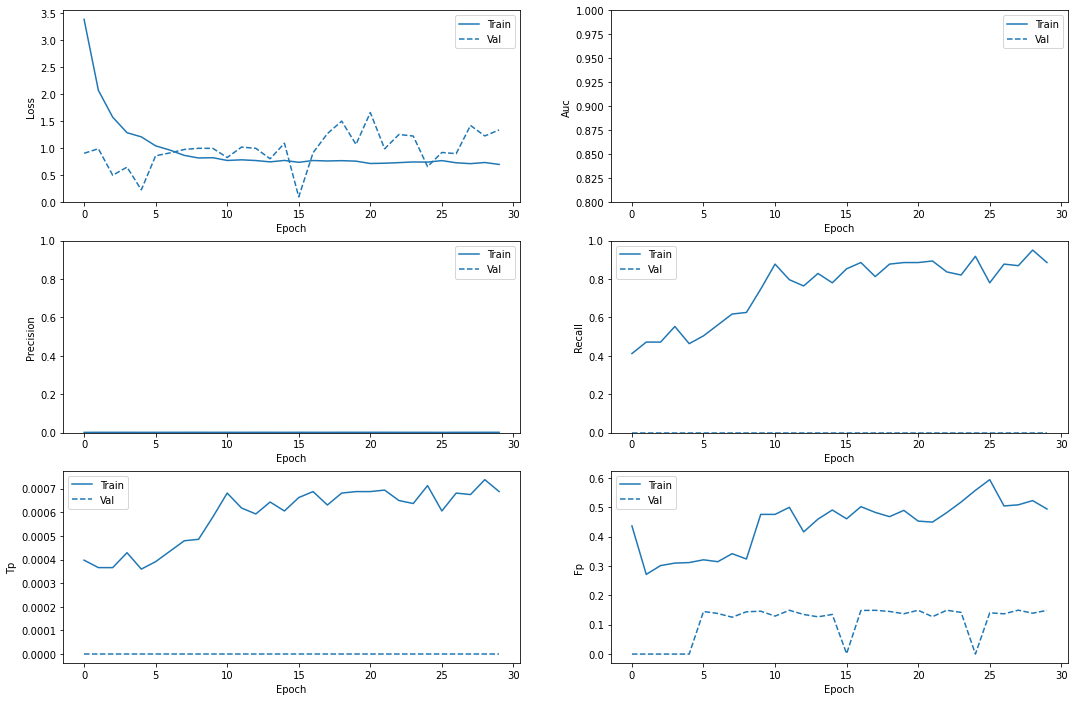

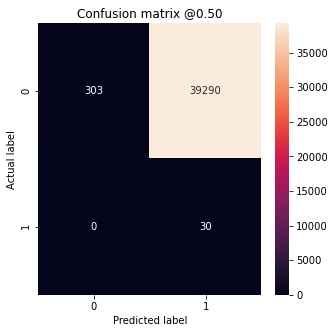

In [118]:
k2_predictions = k2_model.predict(X_K2_test, batch_size=BATCH_SIZE)
plot_metrics(k2_history, X_K2_train)
plot_cm(Y_K2_test, k2_predictions)

The results of training the CNN on the K2 data are not very good as we are basically classifying everything as an exoplanet. My intuition as to why this is happening is because of the large amount of variance in the positive signals and the fact that the raw K2 lightcurves haven't had any stabilisation/feature engineering done like the Kaggle dataset appears to have. A lot of the K2 curves experience consistent increase/decrease in intensity over time and there are often significant features (jumps in the intensity) which ideally should be removed which I believe may be being identified as the representatives patterns as opposed to the actual periodic intensity drops we are looking for.

### Model trained using the Kaggle lightcurves

In [110]:
# Train the model
kaggle_model = make_model(X_ktrain, output_bias=kaggle_bias)

weight_for_0 = (1 / knon_planets) * (ktotal)/2
weight_for_1 = (1 / kplanets) * (ktotal)/2

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

kaggle_history = kaggle_model.fit(
    X_ktrain,
    Y_ktrain,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=None,
    validation_split=VAL_SPLIT,
    class_weight=class_weight
)

Weight for class 0: 0.50
Weight for class 1: 68.74
Epoch 1/20
87/87 [==============================] - 4s 30ms/step - loss: 4.4173 - tp: 9.0568 - fp: 378.7841 - tn: 2389.9432 - fn: 16.0341 - accuracy: 0.8939 - precision: 0.1053 - recall: 0.3579 - auc: 0.6334 - val_loss: 1.7546 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 764.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/20
87/87 [==============================] - 2s 23ms/step - loss: 2.8824 - tp: 11.4432 - fp: 440.2500 - tn: 1765.8977 - fn: 6.2273 - accuracy: 0.8033 - precision: 0.0208 - recall: 0.5308 - auc: 0.5778 - val_loss: 1.6378 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 764.0000 - val_fn: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 3/20
87/87 [==============================] - 2s 24ms/step - loss: 2.2034 - tp: 19.1932 - fp: 497.5000 - tn: 1703.0568 - fn: 4.06

In [111]:
kaggle_results = kaggle_model.evaluate(X_ktest, Y_ktest, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(kaggle_results[0]))
print("\nAccuracy: {:0.4f}".format(kaggle_results[5]))
print("\nPrecision: {:0.4f}".format(kaggle_results[6]))
print("\nRecall: {:0.4f}".format(kaggle_results[7]))

Loss: 0.6804

Accuracy: 0.9947

Precision: 0.6667

Recall: 0.8000


No Planet (True Negatives):  563
False Planets Detected (False Positives):  2
True Planets Missed (False Negatives):  1
True Planets Detected (True Positives):  4
Total Planets:  5


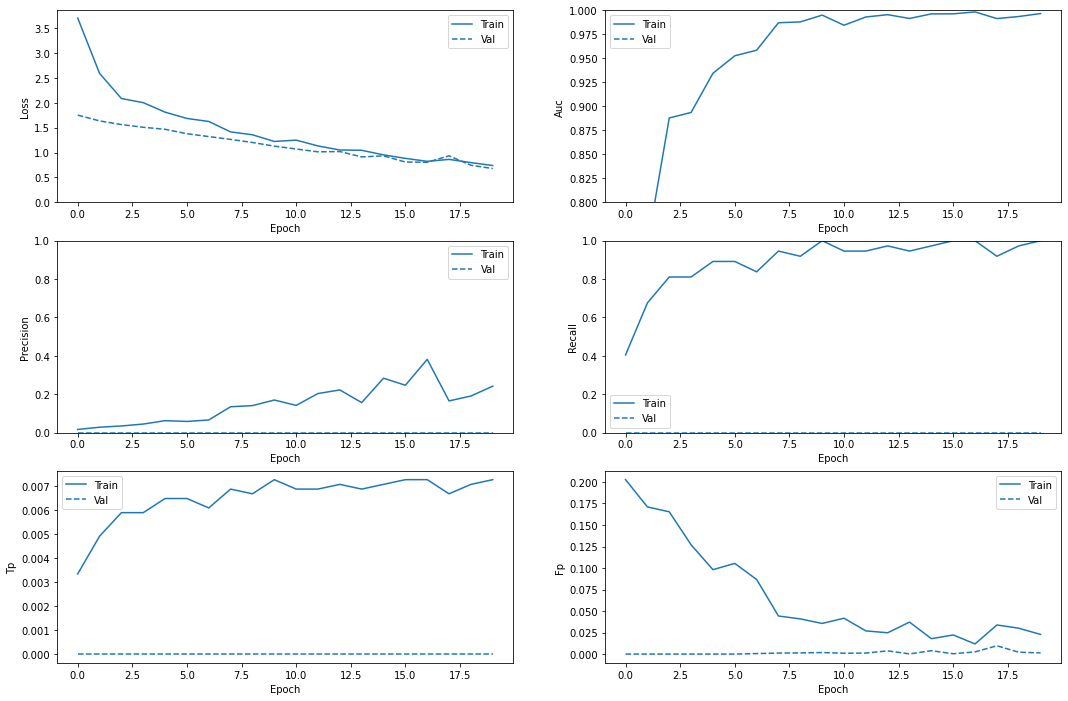

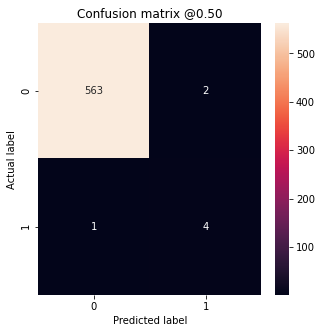

In [112]:
kaggle_predictions = kaggle_model.predict(X_ktest, batch_size=BATCH_SIZE)
plot_metrics(kaggle_history, X_ktrain)
plot_cm(Y_ktest, kaggle_predictions)

The results of training the CNN on only the Kaggle lightcurves and testing the model on the Kaggle Test set has shown pretty good results as we have managed to sucessfully identify 4/5 planets and only mis-classify 2 non-planets. I think this is highly successful given the amount of noise and the significant differences between each positive class.

No Planet (True Negatives):  38567
False Planets Detected (False Positives):  1026
True Planets Missed (False Negatives):  30
True Planets Detected (True Positives):  0
Total Planets:  30


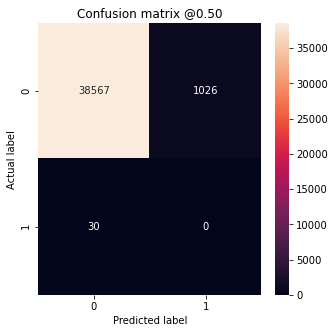

In [119]:
cross_test = kaggle_model.predict(X_K2_test, batch_size=BATCH_SIZE)
plot_cm(Y_K2_test, cross_test)

No Planet (True Negatives):  0
False Planets Detected (False Positives):  565
True Planets Missed (False Negatives):  0
True Planets Detected (True Positives):  5
Total Planets:  5


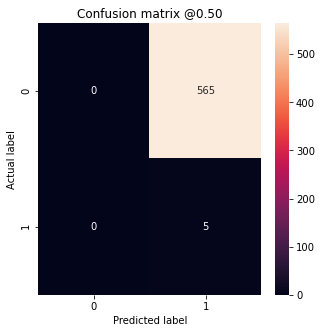

In [120]:
cross_test_2 = k2_model.predict(X_ktest, batch_size=BATCH_SIZE)
plot_cm(Y_ktest, cross_test_2)

Cross testing the Kaggle model on the K2 data and the K2 model on the Kaggle data shows that there is definitely a significant difference between the two models. The Kaggle model fails to classify any of the exoplanets in the K2 test set, indicating that the model is incapable of detecting the features in this set. Whereas the K2 model predicts exoplanet for every lightcurve in the kaggle test set. This is also not good...

Out of interest, lets run the feature engineering and data cleansing on the K2 Candidates and run both of these through our models to see if we can identify anything of note...

In [123]:
candidates = candidates.drop('label', axis=1)
# Front align all the data
candidates = candidates.apply(align, axis=1)

# Subset the K2 data so it is equivalent length/features as the kaggle data
candidates = candidates.shift(1, axis=1).drop('0', axis=1)[ktrain.columns]

# Remove any K2 data which does not meet the minimum feature length requirements
candidates = candidates[~candidates.isna().any(axis=1)]

candidates

,1,2,3,4,5,6,7,8,9,10,...,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197
EPIC 219388192,0.996213,0.996283,0.996137,0.996264,0.996008,0.996006,0.996262,0.996201,0.995229,0.996026,...,0.996217,0.995855,0.995782,0.995875,0.995947,0.996147,0.996587,0.996708,0.996357,0.996509
EPIC 218621322,0.999133,0.998948,0.998866,0.998851,0.998720,0.998440,0.998780,0.998706,0.999234,0.998140,...,1.001236,1.001020,1.000942,1.001090,1.001332,1.000874,1.001053,1.000872,1.001051,1.000965
EPIC 216050437,0.998807,0.998398,0.998265,0.998339,0.998212,0.998225,0.997873,0.998055,0.997847,0.999450,...,0.993035,0.993156,0.993230,0.993078,0.993005,0.993108,0.993144,0.993207,0.993043,0.993376
EPIC 213123443,1.000341,0.999910,0.999959,1.000037,0.999866,0.999915,0.999906,0.999688,0.999976,1.000239,...,1.003775,1.003526,1.003898,1.003375,1.003252,1.003683,1.003703,1.003499,1.003455,1.003574
EPIC 218668602,0.995616,0.996253,0.996404,0.996484,0.996011,0.996159,0.995961,0.995929,0.996249,0.993867,...,1.007351,1.006709,1.007131,1.006696,1.006681,1.006873,1.006765,1.007142,1.007047,1.007346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPIC 211510580,0.964899,0.964214,0.963830,0.962911,0.962656,0.962898,0.961357,0.959750,0.960366,0.958934,...,0.980218,0.980940,0.980571,0.980959,0.981233,0.980605,0.981014,0.980036,0.979918,0.981429
EPIC 211837343,0.984501,0.984089,0.984521,0.983959,0.984000,0.984320,0.983596,0.983228,0.983508,0.983928,...,0.987770,0.986796,0.986535,0.986990,0.986782,0.987601,0.987902,0.987523,0.988555,0.987825
EPIC 211978988,0.998657,0.998929,0.998871,0.998893,0.998676,0.998860,0.998774,0.998767,0.998613,0.998812,...,0.999237,0.999151,0.999253,0.999276,0.999171,0.999252,0.999283,0.999200,0.999153,0.999280
EPIC 211418290,0.948123,0.946994,0.945692,0.945008,0.944274,0.943785,0.943309,0.942931,0.942526,0.941875,...,0.981230,0.976443,0.978675,0.977554,0.978164,0.979175,0.980429,0.980255,0.981178,0.981148


In [124]:
candidates = zero_outlier_removal(candidates)
# Remove 2% of the positive spikes
candidates = spike_removal(candidates, 2)
# Apply frequency filtering
candidates = frequency_filter(candidates, 4, 20)

candidates

,1,2,3,4,5,6,7,8,9,10,...,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197
EPIC 219388192,0.996308,0.996221,0.996154,0.996105,0.996068,0.996040,0.996017,0.995998,0.995978,0.995958,...,0.995945,0.996049,0.996132,0.996198,0.996249,0.996292,0.996334,0.996386,0.996459,0.996566
EPIC 218621322,0.999026,0.998990,0.998936,0.998870,0.998797,0.998722,0.998648,0.998578,0.998513,0.998456,...,1.000939,1.000954,1.000958,1.000954,1.000942,1.000926,1.000909,1.000899,1.000899,1.000919
EPIC 216050437,0.998894,0.998437,0.998183,0.998080,0.998087,0.998163,0.998278,0.998402,0.998515,0.998598,...,0.993179,0.993131,0.993093,0.993068,0.993059,0.993067,0.993095,0.993144,0.993216,0.993310
EPIC 213123443,1.000247,1.000075,0.999967,0.999908,0.999887,0.999893,0.999916,0.999948,0.999981,1.000010,...,1.003307,1.003322,1.003345,1.003374,1.003407,1.003440,1.003472,1.003498,1.003513,1.003514
EPIC 218668602,0.995654,0.996168,0.996410,0.996446,0.996333,0.996125,0.995864,0.995588,0.995327,0.995104,...,1.006928,1.006889,1.006840,1.006786,1.006739,1.006709,1.006709,1.006757,1.006869,1.007066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPIC 211510580,0.964363,0.964405,0.964148,0.963651,0.962969,0.962150,0.961241,0.960283,0.959313,0.958364,...,0.980877,0.980856,0.980815,0.980761,0.980701,0.980648,0.980614,0.980614,0.980666,0.980790
EPIC 211837343,0.984491,0.984320,0.984180,0.984066,0.983973,0.983897,0.983833,0.983778,0.983727,0.983677,...,0.986780,0.986791,0.986845,0.986940,0.987067,0.987216,0.987372,0.987515,0.987623,0.987670
EPIC 211978988,0.998746,0.998809,0.998840,0.998846,0.998835,0.998812,0.998783,0.998751,0.998720,0.998691,...,0.999238,0.999230,0.999223,0.999217,0.999213,0.999212,0.999214,0.999220,0.999230,0.999246
EPIC 211418290,0.947726,0.946951,0.946163,0.945377,0.944606,0.943860,0.943149,0.942478,0.941854,0.941280,...,0.978983,0.978885,0.978805,0.978776,0.978833,0.979013,0.979358,0.979912,0.980723,0.981841


In [136]:
X_candidates = np.expand_dims(candidates.copy(), axis=2).astype(float)

k2_cand_pred = k2_model.predict(X_candidates, batch_size=BATCH_SIZE)
k_cand_pred = kaggle_model.predict(X_candidates, batch_size=BATCH_SIZE)

print(f'k2 model \nplanets = {(k2_cand_pred.round() == 1).sum()}')
print(f'total = {k2_cand_pred.round().size}')

print(f'\n \nkaggle model \nplanets = {(k_cand_pred.round() == 1).sum()}')
print(f'total = {k_cand_pred.round().size}')

k2 model 
planets = 599
total = 605

 
kaggle model 
planets = 14
total = 605


k2 model predicts 1 for basically all the candidates so we will ignore that. The kaggle model has predicted planet for 14 out of the 605 possible candidates, lets plot these and see if they have obvious exoplanet signals...

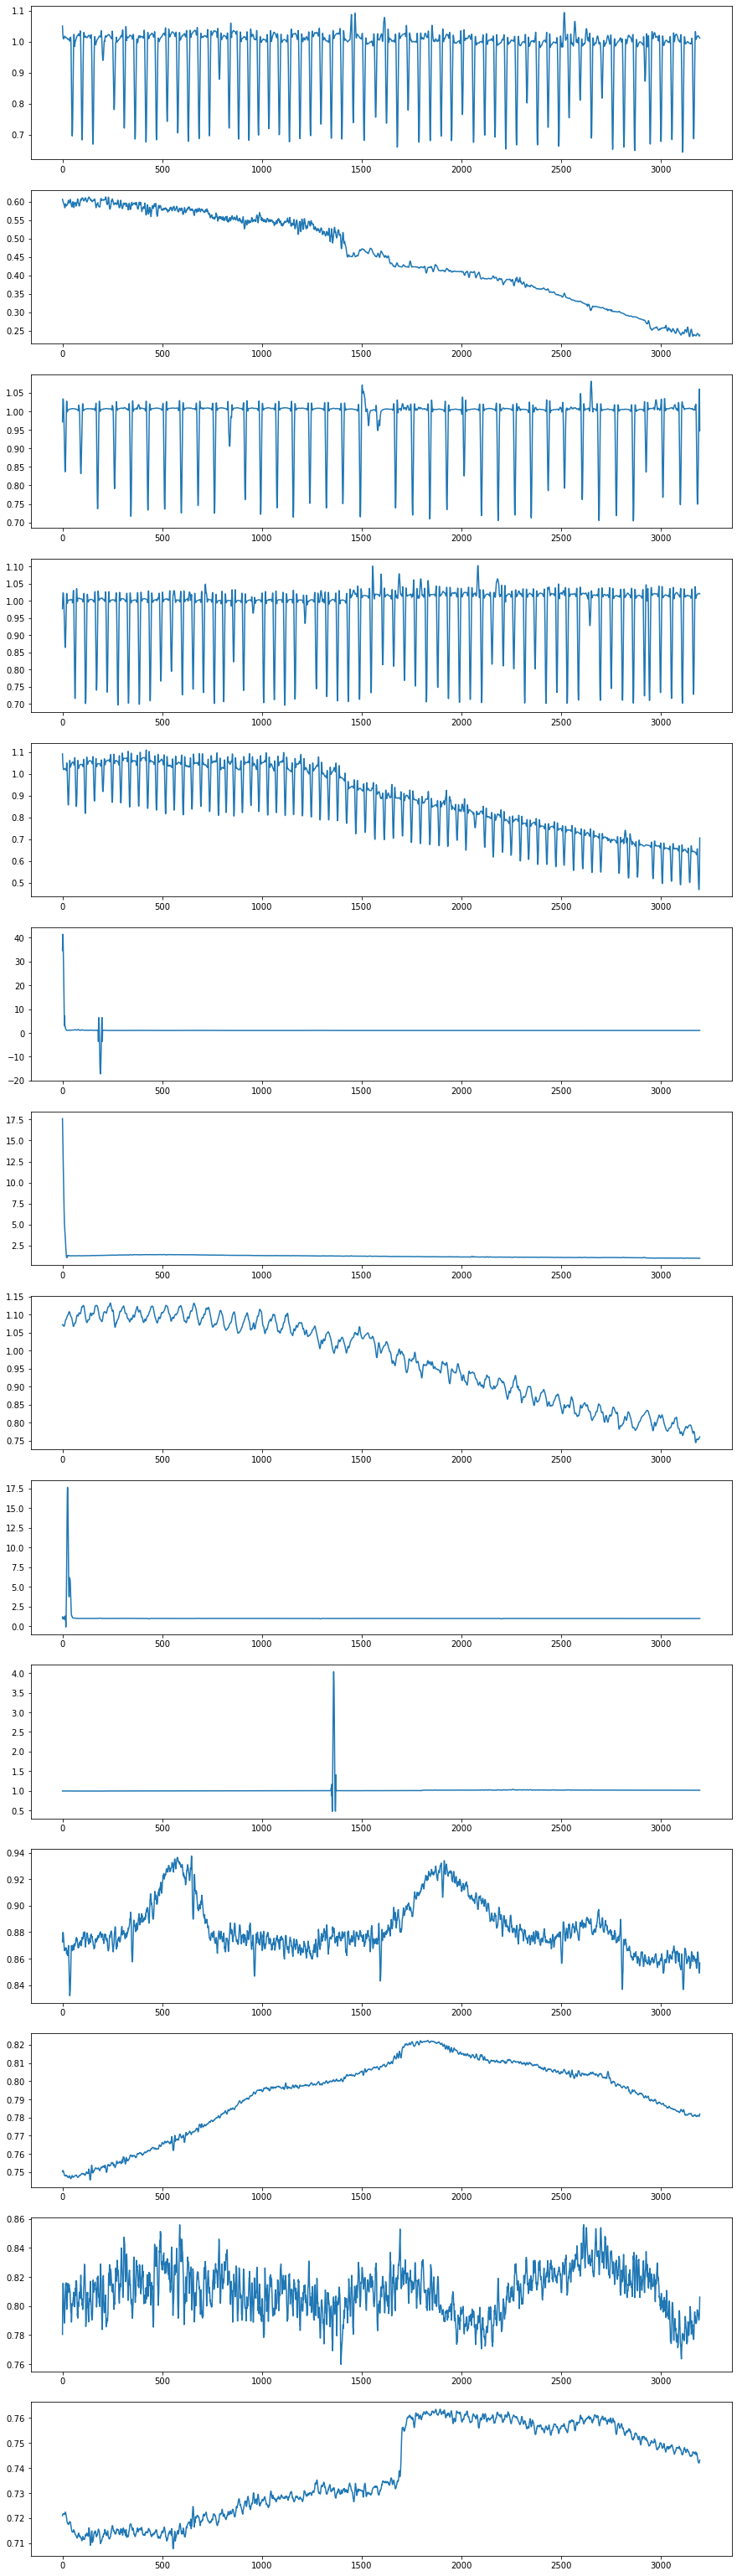

In [169]:
idx = np.where(k_cand_pred.round() == 1)[0]
planet_candidates = X_candidates[idx, :, :].squeeze()

fix, axes = plt.subplots(len(planet_candidates), 1, figsize=(15, 4*len(planet_candidates)))

for i, ax in enumerate(axes):
    ax.plot(planet_candidates[i])

We can clearly see some very obvious exo-planet like signals have been identified in the candidates (0, 2, 3, 4) and if we look closely there also seem to be some more nuanced identifications of small transiting planets (1, 10, 11, 13).

Given the noisy nature of the signals, and the fact that exo-planet signals are highly varied depending on the size of the star, the size of the planet, and the orbital period of the planets, I think the results here are reasonably good as we have managed to clearly identify periodic features that emulate that of exo-planet transisitions in data that is completely unseen to the models.